In [1]:
import numpy as np

def generate_koch_snowflake(iterations):
    """
    Generate ordered vertices of the Koch snowflake at a given iteration.
    The initial shape is an equilateral triangle.
    
    Returns:
        vertices : np.ndarray of shape (N, 2)
    """
    angle_offset = np.pi / 6  # Rotate so base is flat
    angles = np.array([0, 2*np.pi/3, 4*np.pi/3]) + angle_offset
    vertices = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    vertices = np.vstack([vertices, vertices[0]])  # Close triangle

    for _ in range(iterations):
        new_vertices = []
        for i in range(len(vertices) - 1):
            p0 = vertices[i]
            p1 = vertices[i + 1]
            delta = p1 - p0
            one_third = p0 + delta / 3
            two_third = p0 + 2 * delta / 3
            length = np.linalg.norm(delta) / 3
            angle = np.arctan2(delta[1], delta[0]) - np.pi/3
            peak = np.array([
                one_third[0] + length * np.cos(angle),
                one_third[1] + length * np.sin(angle)
            ])
            new_vertices.extend([p0, one_third, peak, two_third])
        new_vertices.append(vertices[-1])
        vertices = np.array(new_vertices)

    return vertices


In [2]:
import matplotlib.pyplot as plt
from skimage.draw import line

def draw_line(y0, x0, y1, x1):
    return line(y0, x0, y1, x1)

def rasterize_koch_snowflake(vertices, target_max_dim=None, padding=0):
    """
    Rasterize the Koch snowflake into a binary image fitted to the bounding box.
    """
    min_x, min_y = vertices.min(axis=0)
    max_x, max_y = vertices.max(axis=0)
    width = max_x - min_x
    height = max_y - min_y

    if target_max_dim is not None:
        scale = target_max_dim / max(width, height)
    else:
        scale = 1.0

    centered = (vertices - np.array([min_x, min_y])) * scale + padding
    snapped = np.round(centered).astype(np.int32)

    img_width = snapped[:, 0].max() + 1 + padding
    img_height = snapped[:, 1].max() + 1 + padding
    img = np.zeros((img_height, img_width), dtype=bool)

    for i in range(len(snapped)):
        p1 = snapped[i]
        p2 = snapped[(i + 1) % len(snapped)]
        rr, cc = draw_line(p1[1], p1[0], p2[1], p2[0])
        rr = np.clip(rr, 0, img_height - 1)
        cc = np.clip(cc, 0, img_width - 1)
        img[rr, cc] = True

    return img


In [3]:
from scipy.ndimage import label

def flood_fill(img):
    """
    Fill the interior of the fractal by labeling background
    and inverting the mask.
    """
    filled = img.copy()
    labeled, _ = label(~filled)
    background_label = labeled[0,0]
    mask = labeled != background_label
    return mask


In [4]:
from scipy.ndimage import convolve

def measure_area_perimeter(img):
    """
    Measure area and perimeter using convolution for more precision.
    
    Area: simple pixel sum.
    Perimeter: pixels that have at least one background neighbor.
    """
    A = np.sum(img)
    
    # 3x3 kernel to count neighbors
    kernel = np.array([[1,1,1],
                       [1,0,1],
                       [1,1,1]])
    
    neighbor_count = convolve(img.astype(np.uint8), kernel, mode='constant', cval=0)
    
    # Perimeter pixels: foreground pixels with any background neighbor
    perimeter_pixels = ((img == 1) & (neighbor_count < 8))
    P = np.sum(perimeter_pixels)
    
    return A, P

In [5]:
from tqdm import tqdm

def estimate_D_full_fractal(
    iterations=7,
    min_size=30,
    max_size=64000,
    num_sizes=60,
    padding=10
):
    """
    Estimate D for the full Koch snowflake fractal.
    """
    vertices = generate_koch_snowflake(iterations=iterations)
    sizes = np.logspace(np.log10(min_size), np.log10(max_size), num=num_sizes)

    areas = []
    perimeters = []

    for size in tqdm(sizes, desc="Raster Sizes"):
        img = rasterize_koch_snowflake(vertices, target_max_dim=int(size), padding=padding)
        img = flood_fill(img)
        A, P = measure_area_perimeter(img)
        areas.append(A)
        perimeters.append(P)

    areas = np.array(areas)
    perimeters = np.array(perimeters)

    logA = np.log(areas)
    logP = np.log(perimeters)
    slope, intercept = np.polyfit(logA, logP, 1)
    D_est = slope * 2

    # Plot
    plt.figure(figsize=(6,4))
    plt.scatter(logA, logP, label="Data")
    plt.plot(logA, slope*logA + intercept, color='red', label=f"Fit: slope={slope:.8f}")
    plt.xlabel("log(Area)")
    plt.ylabel("log(Perimeter)")
    plt.title(f"Full Fractal D Estimate\nIterations={iterations}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return D_est


In [42]:
# D_est = estimate_D_full_fractal(
#     iterations=9, 
#     min_size=500, 
#     max_size=8000, 
#     num_sizes=30, 
#     padding=10
# )

# print(f"Estimated D: {D_est:.8f}")
# print(f"True D: {np.log(4)/np.log(3):.8f}")


In [6]:
def slice_and_mirror(vertices, fraction=2/3, axis='x'):
    """
    Slice a vectorized Koch snowflake at a given fraction along the fractal coordinates (not image),
    mirror the kept portion across the slice plane, and stitch the halves together.
    
    Parameters:
        vertices : (N,2) np.ndarray
            Ordered vertices of the closed fractal.
        fraction : float
            Fraction along fractal axis to slice at (0 = min, 1 = max).
        axis : str
            'x' for vertical slice, 'y' for horizontal slice.
            
    Returns:
        new_vertices : (M,2) np.ndarray
            Sliced, mirrored, stitched vertices.
    """
    if axis not in ['x', 'y']:
        raise ValueError("axis must be 'x' or 'y'")
    if not (0 <= fraction <= 1):
        raise ValueError("fraction must be between 0 and 1 inclusive")

    # Axis index
    idx = 0 if axis == 'x' else 1

    # Fractal coordinate span
    coords = vertices[:, idx]
    min_val, max_val = coords.min(), coords.max()
    slice_val = min_val + fraction * (max_val - min_val)

    kept_vertices = []

    # Walk through edges
    for i in range(len(vertices) - 1):
        p0 = vertices[i]
        p1 = vertices[i + 1]
        v0, v1 = p0[idx], p1[idx]

        if v0 <= slice_val:
            kept_vertices.append(p0)

        # Edge crosses slice plane
        if (v0 - slice_val) * (v1 - slice_val) < 0:
            t = (slice_val - v0) / (v1 - v0)
            crossing = p0 + t * (p1 - p0)
            kept_vertices.append(crossing)

    if len(kept_vertices) == 0:
        raise ValueError(f"No vertices remain after slicing at fraction {fraction:.2f}.")

    kept_vertices = np.array(kept_vertices)

    # Mirror
    mirrored = kept_vertices.copy()
    mirrored[:, idx] = 2 * slice_val - mirrored[:, idx]
    mirrored = mirrored[::-1]  # Reverse to maintain orientation

    # Stitch original + mirrored + close loop
    new_vertices = np.vstack([
        kept_vertices,
        mirrored,
        kept_vertices[0:1]  # Close
    ])

    return new_vertices


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def main_pipeline(
    iterations=7,
    min_size=500,
    max_size=8000,
    num_sizes=1,
    padding=10,
    fractions=np.linspace(0.1, 0.9, 9)
):
    # 1. Estimate true D for full fractal
    print("Estimating true D...")
    vertices_full = generate_koch_snowflake(iterations=iterations)
    
    sizes = np.logspace(np.log10(min_size), np.log10(max_size), num=num_sizes)
    areas_full = []
    perimeters_full = []
    
    for size in tqdm(sizes, desc="Raster sizes for full fractal"):
        img = rasterize_koch_snowflake(vertices_full, target_max_dim=int(size), padding=padding)
        img = flood_fill(img)
        A, P = measure_area_perimeter(img)
        areas_full.append(A)
        perimeters_full.append(P)
        
    logA_full = np.log(areas_full)
    logP_full = np.log(perimeters_full)
    slope_full, intercept_full = np.polyfit(logA_full, logP_full, 1)
    D_true = slope_full * 2

    print(f"True Estimated D: {D_true:.8f}")

    # 2. For each fraction, slice, mirror, rasterize, measure D
    D_estimates = []
    delta_Ds = []

    for frac in tqdm(fractions, desc="Fractions"):
        vertices_sliced = slice_and_mirror(vertices_full, fraction=frac, axis='x')
        
        areas = []
        perimeters = []
        
        for size in tqdm(sizes, desc=f"Sizes for fraction {frac:.2f}"):
            img = rasterize_koch_snowflake(vertices_sliced, target_max_dim=int(size), padding=padding)
            img = flood_fill(img)
            A, P = measure_area_perimeter(img)
            areas.append(A)
            perimeters.append(P)
        
        areas = np.array(areas)
        perimeters = np.array(perimeters)
        
        logA = np.log(areas)
        logP = np.log(perimeters)
        slope, intercept = np.polyfit(logA, logP, 1)
        D_est = slope * 2
        delta_D = D_est - D_true

        D_estimates.append(D_est)
        delta_Ds.append(delta_D)
        
        # Plot the smallest rasterized image for sanity check
        img_smallest = rasterize_koch_snowflake(vertices_sliced, target_max_dim=int(sizes[0]), padding=padding)
        img_smallest = flood_fill(img_smallest)
        
        plt.figure(figsize=(5,5))
        plt.imshow(img_smallest, cmap='gray')
        plt.title(f"Fraction {frac:.2f}\nSmallest Raster Size")
        plt.axis('off')
        plt.show()

    # 3. Plot D estimates vs fraction
    plt.figure(figsize=(8,5))
    plt.plot(fractions, D_estimates, 'o-', label="Estimated D")
    plt.axhline(D_true, color='red', linestyle='--', label="True D")
    plt.xlabel("Slice Fraction")
    plt.ylabel("Estimated D")
    plt.title("D Estimate vs Fraction")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Plot Delta D vs fraction
    plt.figure(figsize=(8,5))
    plt.plot(fractions, delta_Ds, 'o-', color='purple', label="Delta D")
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Slice Fraction")
    plt.ylabel("Delta D (D_est - D_true)")
    plt.title("Delta D vs Fraction")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'fractions': fractions,
        'D_estimates': D_estimates,
        'delta_Ds': delta_Ds,
        'D_true': D_true
    }


Estimating true D...


Raster sizes for full fractal: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


True Estimated D: 1.34215592


Sizes for fraction 0.05: 100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


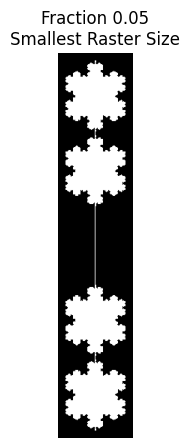

Sizes for fraction 0.08: 100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


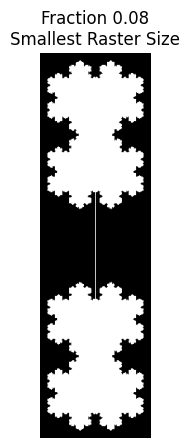

Sizes for fraction 0.11: 100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


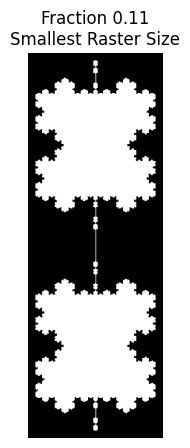

Sizes for fraction 0.15: 100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


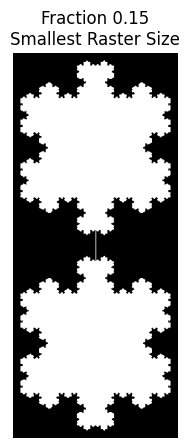

Sizes for fraction 0.18: 100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


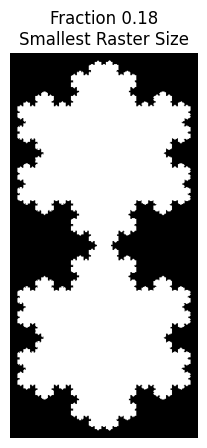

Sizes for fraction 0.21: 100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


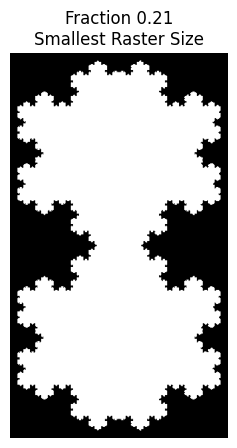

Sizes for fraction 0.24: 100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


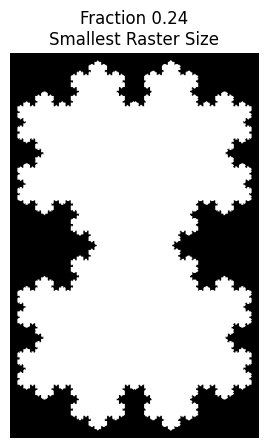

Sizes for fraction 0.27: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


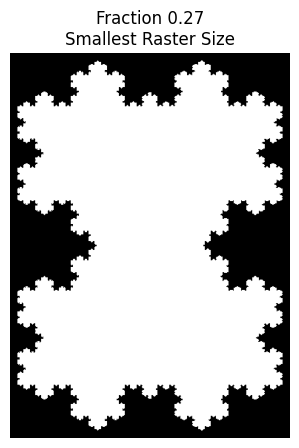

Sizes for fraction 0.31: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


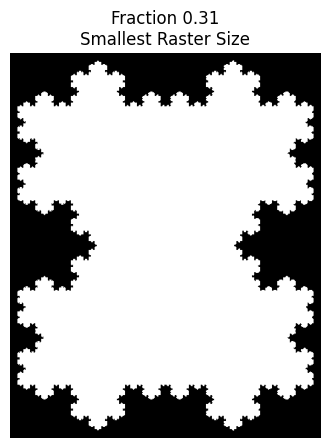

Sizes for fraction 0.34: 100%|██████████| 30/30 [00:44<00:00,  1.50s/it]


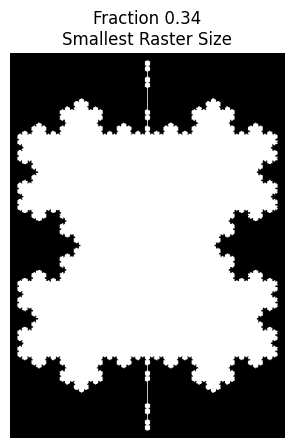

Sizes for fraction 0.37: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


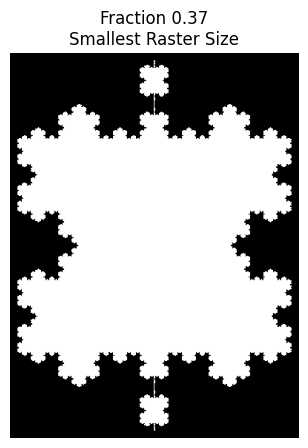

Sizes for fraction 0.40: 100%|██████████| 30/30 [00:53<00:00,  1.77s/it]


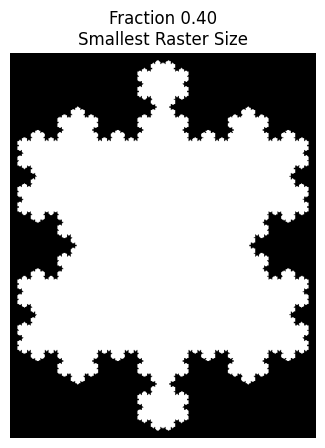

Sizes for fraction 0.44: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it]


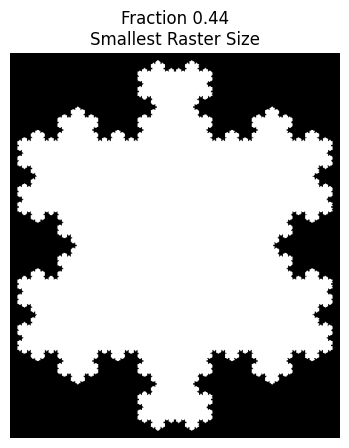

Sizes for fraction 0.47: 100%|██████████| 30/30 [00:58<00:00,  1.94s/it]


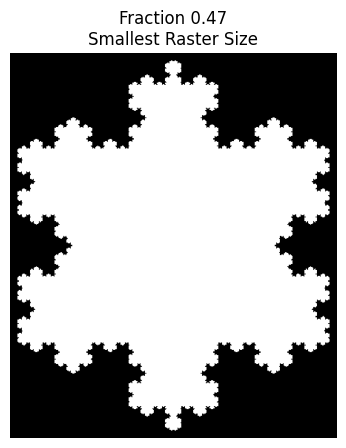

Sizes for fraction 0.50: 100%|██████████| 30/30 [01:02<00:00,  2.08s/it]


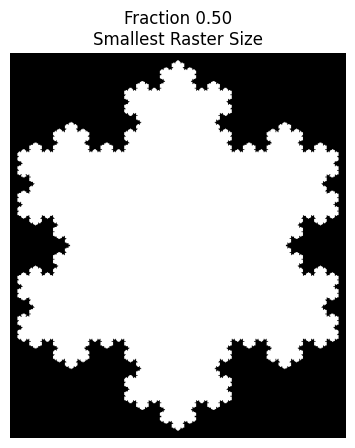

Sizes for fraction 0.53: 100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


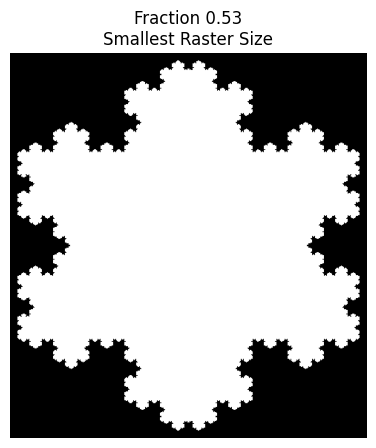

Sizes for fraction 0.56: 100%|██████████| 30/30 [01:05<00:00,  2.19s/it]


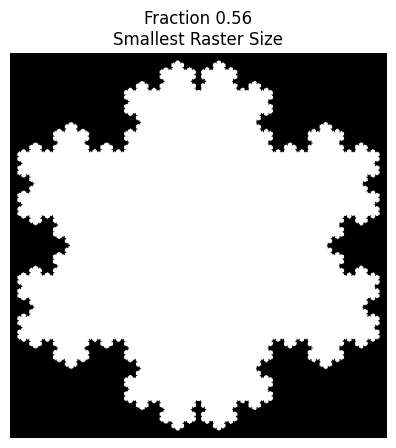

Sizes for fraction 0.60: 100%|██████████| 30/30 [01:06<00:00,  2.23s/it]


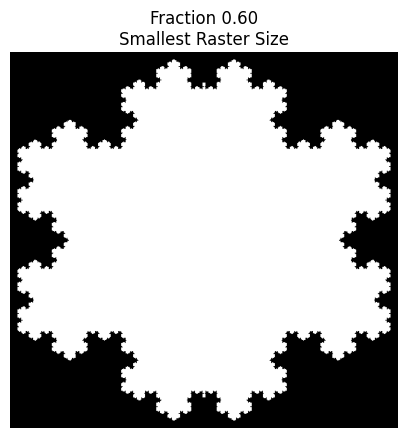

Sizes for fraction 0.63: 100%|██████████| 30/30 [01:09<00:00,  2.30s/it]


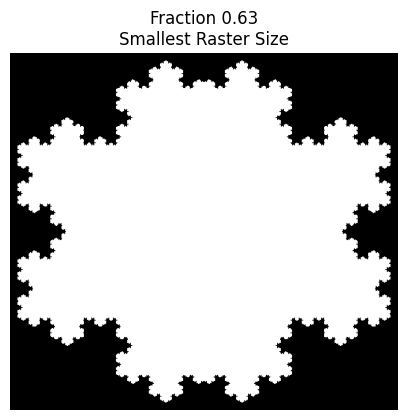

Sizes for fraction 0.66: 100%|██████████| 30/30 [01:11<00:00,  2.40s/it]


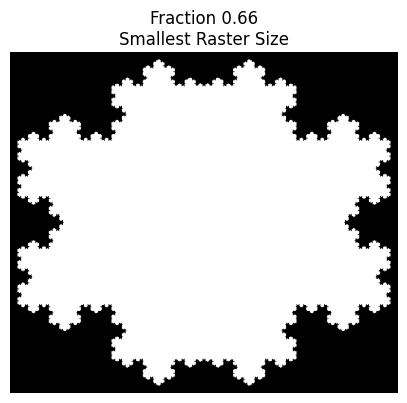

Sizes for fraction 0.69: 100%|██████████| 30/30 [01:16<00:00,  2.56s/it]


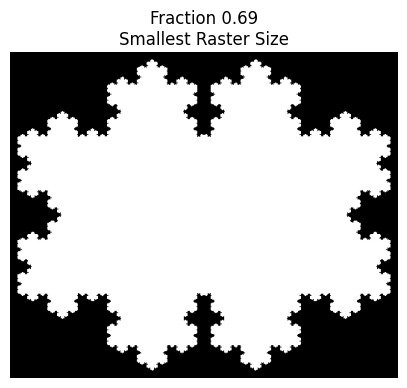

Sizes for fraction 0.72: 100%|██████████| 30/30 [01:14<00:00,  2.50s/it]


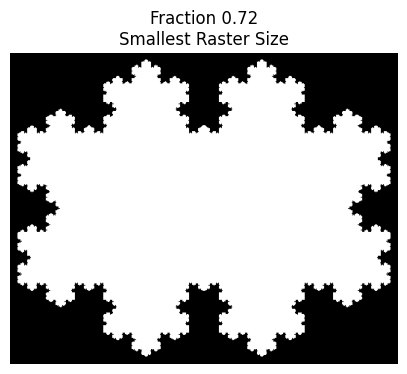

Sizes for fraction 0.76: 100%|██████████| 30/30 [01:17<00:00,  2.58s/it]


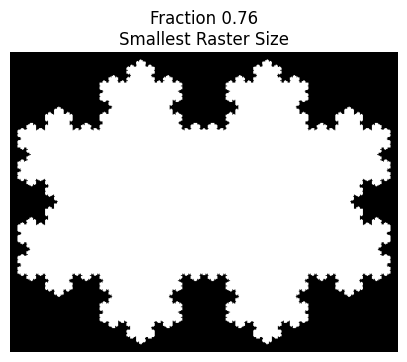

Sizes for fraction 0.79: 100%|██████████| 30/30 [01:19<00:00,  2.64s/it]


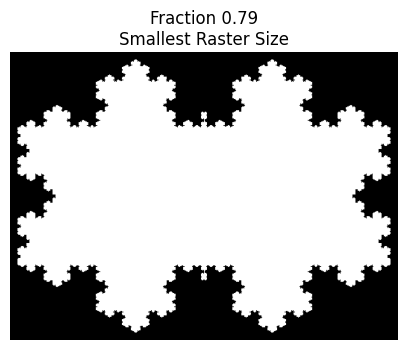

Sizes for fraction 0.82: 100%|██████████| 30/30 [01:23<00:00,  2.77s/it]


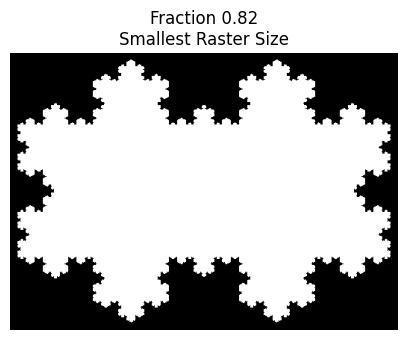

Sizes for fraction 0.85: 100%|██████████| 30/30 [01:22<00:00,  2.76s/it]


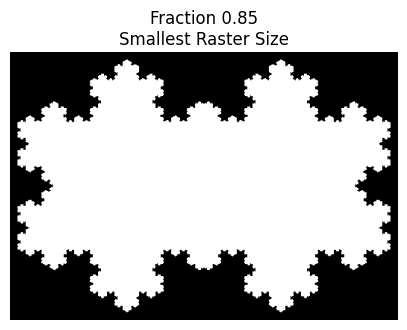

Sizes for fraction 0.89: 100%|██████████| 30/30 [01:27<00:00,  2.91s/it]


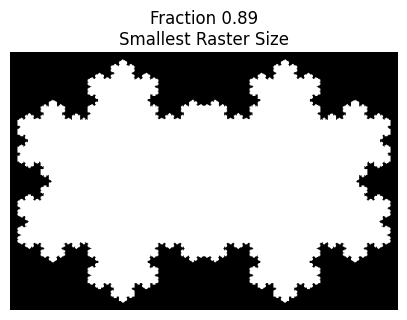

Sizes for fraction 0.92: 100%|██████████| 30/30 [01:30<00:00,  3.00s/it]


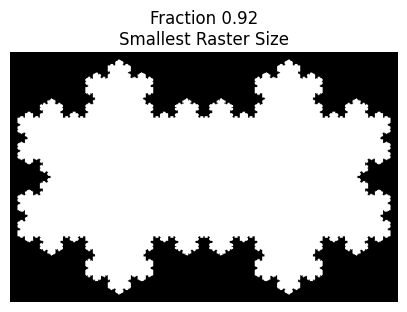

Sizes for fraction 0.95: 100%|██████████| 30/30 [01:33<00:00,  3.11s/it]


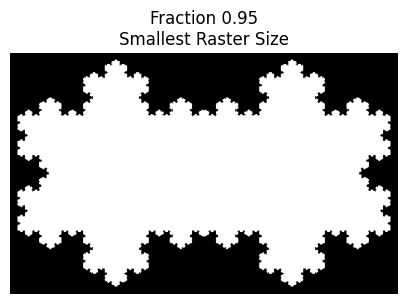

Fractions: 100%|██████████| 29/29 [28:49<00:00, 59.63s/it]


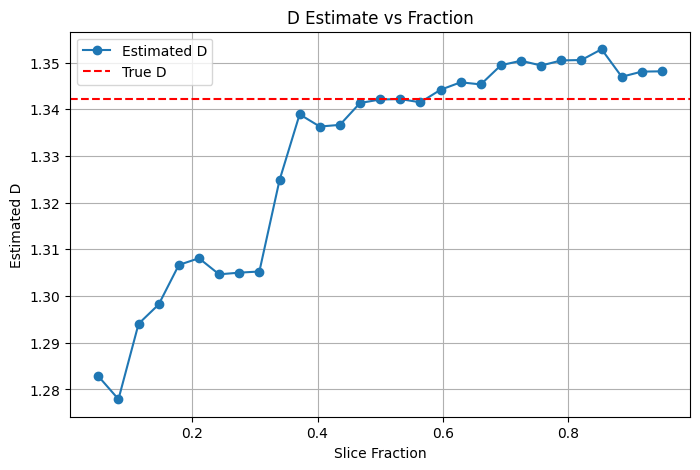

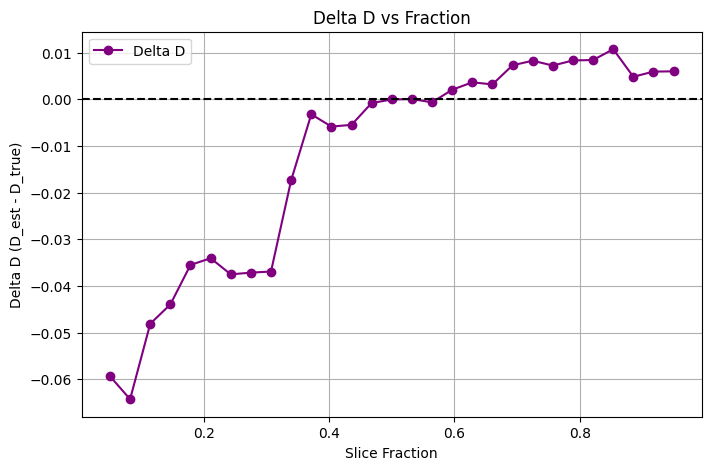

In [8]:
results = main_pipeline(iterations=7,
    min_size=500,
    max_size=8000,
    num_sizes=30,
    padding=10,
    fractions=np.linspace(0.05, 0.95, 29))

In [48]:
print(results)

{'fractions': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'D_estimates': [np.float64(1.2716619665848443), np.float64(1.275284032863876), np.float64(1.2737533035691464), np.float64(1.2743743904792302), np.float64(1.2682558390477852), np.float64(1.2686815184643394), np.float64(1.2683146021940037), np.float64(1.2706325232553868), np.float64(1.2657787887487342)], 'delta_Ds': [np.float64(0.003402532205747155), np.float64(0.007024598484778766), np.float64(0.005493869190049239), np.float64(0.006114956100133018), np.float64(-3.595331312000738e-06), np.float64(0.00042208408524224694), np.float64(5.516781490655376e-05), np.float64(0.0023730888762896196), np.float64(-0.0024806456303629876)], 'D_true': np.float64(1.2682594343790972)}


In [53]:
import pandas as pd

df_results = pd.DataFrame(results)
df_results.to_csv("koch_sliced_19.csv", index=False)